# Traveling Salesman problem with Genetic algorithm

Code by: Eric Stoltz

Reference: https://towardsdatascience.com/evolution-of-a-salesman-a-complete-genetic-algorithm-tutorial-for-python-6fe5d2b3ca35

Stand: 24.10.2021

The following notebook contains an example solution of the TSP by using a genetic algorithm.

### Import the Python modules needed for the solution.

In [40]:
import numpy as np, random, operator
import pandas as pd
import matplotlib.pyplot as plt

### Destinations

Create a City class where each city is a destination we wish to visit. The class contains the (x,y) coordinates of the city, as well as the distance between each pair of cities.

In [41]:
class City:
    def __init__(self, x, y):
        self.x = x
        self.y = y

    def distance(self, city):
        xDis = abs(self.x - city.x)
        yDis = abs(self.y - city.y)
        distance = np.sqrt((xDis ** 2) + (yDis ** 2))
        return distance

    def __repr__(self):
        return "(" + str(self.x) + ", " + str(self.y) + ")"

### Create a path going through all destinations

In this line of code we create one sample route that goes through all destinations.

In [42]:
def createRoute(cityList):
    route = random.sample(cityList, len(cityList))
    return route

### Create an initial population

The initial population is a subset of sample paths. In this line of code we create multiple sample paths and save them in the initial population.

In [43]:
def initialPopulation(popSize, cityList):
    population = []

    for i in range(0, popSize):
        population.append(createRoute(cityList))
    return population

### Create a fitness function

First create a class *fitness* where we calculate the fitness value of each route. The fitness value is the inverse of the route cost (as mentioned in *EA Lab 2.pdf*). In this function we take into account that the route starts and ends at the same node of the graph.

In [44]:
class Fitness:
    def __init__(self, route):
        self.route = route
        self.distance = 0
        self.fitness= 0.0

    def routeDistance(self):
        if self.distance ==0:
            pathDistance = 0
            for i in range(0, len(self.route)):
                fromCity = self.route[i]
                toCity = None
                if i + 1 < len(self.route):
                    toCity = self.route[i + 1]
                else:
                    toCity = self.route[0]
                pathDistance += fromCity.distance(toCity)
            self.distance = pathDistance
        return self.distance

    def routeFitness(self):
        if self.fitness == 0:
            self.fitness = 1 / float(self.routeDistance())
        return self.fitness

### Determine fitness of each gene in the population

In [45]:
def rankRoutes(population):
    fitnessResults = {}
    for i in range(0,len(population)):
        fitnessResults[i] = Fitness(population[i]).routeFitness()
    return sorted(fitnessResults.items(), key = operator.itemgetter(1), reverse = True)

### Selection

We select the paths with highest fitness values to be the parents of the next generation. The selected genes are saved in the mating pool.

In [46]:
def selection(popRanked, eliteSize):
    selectionResults = []
    df = pd.DataFrame(np.array(popRanked), columns=["Index","Fitness"])
    df['cum_sum'] = df.Fitness.cumsum()
    df['cum_perc'] = 100*df.cum_sum/df.Fitness.sum()

    for i in range(0, eliteSize):
        selectionResults.append(popRanked[i][0])
    for i in range(0, len(popRanked) - eliteSize):
        pick = 100*random.random()
        for i in range(0, len(popRanked)):
            if pick <= df.iat[i,3]:
                selectionResults.append(popRanked[i][0])
                break
    return selectionResults

In [47]:
def matingPool(population, selectionResults):
    matingpool = []
    for i in range(0, len(selectionResults)):
        index = selectionResults[i]
        matingpool.append(population[index])
    return matingpool

### Ordered Crossover

In the first function we define the ordered crossover. In the second function we peform crossover on the population.

In [48]:
def breed(parent1, parent2):
    child = []
    childP1 = []
    childP2 = []

    geneA = int(random.random() * len(parent1))
    geneB = int(random.random() * len(parent1))

    startGene = min(geneA, geneB)
    endGene = max(geneA, geneB)

    for i in range(startGene, endGene):
        childP1.append(parent1[i])

    childP2 = [item for item in parent2 if item not in childP1]

    child = childP1 + childP2
    return child

In [49]:
def breedPopulation(matingpool, eliteSize):
    children = []
    length = len(matingpool) - eliteSize
    pool = random.sample(matingpool, len(matingpool))

    for i in range(0,eliteSize):
        children.append(matingpool[i])

    for i in range(0, length):
        child = breed(pool[i], pool[len(matingpool)-i-1])
        children.append(child)
    return children

### Mutation

In the first function we define the mutation process. In the second function we run mutation through the population.

In [50]:
def mutate(individual, mutationRate):
    for swapped in range(len(individual)):
        if(random.random() < mutationRate):
            swapWith = int(random.random() * len(individual))

            city1 = individual[swapped]
            city2 = individual[swapWith]

            individual[swapped] = city2
            individual[swapWith] = city1
    return individual

In [51]:
def mutatePopulation(population, mutationRate):
    mutatedPop = []

    for ind in range(0, len(population)):
        mutatedInd = mutate(population[ind], mutationRate)
        mutatedPop.append(mutatedInd)
    return mutatedPop

### Create new generation

In [52]:
def nextGeneration(currentGen, eliteSize, mutationRate):
    popRanked = rankRoutes(currentGen)
    selectionResults = selection(popRanked, eliteSize)
    matingpool = matingPool(currentGen, selectionResults)
    children = breedPopulation(matingpool, eliteSize)
    nextGeneration = mutatePopulation(children, mutationRate)
    return nextGeneration

### The Genetic algorithm

In [53]:
def geneticAlgorithm(population, popSize, eliteSize, mutationRate, generations):
    pop = initialPopulation(popSize, population)
    print("Initial distance: " + str(1 / rankRoutes(pop)[0][1]))

    for i in range(0, generations):
        pop = nextGeneration(pop, eliteSize, mutationRate)

    print("Final distance: " + str(1 / rankRoutes(pop)[0][1]))
    bestRouteIndex = rankRoutes(pop)[0][0]
    bestRoute = pop[bestRouteIndex]

    return bestRoute

### Create a list of destinations and run the GA

In [54]:
def plot(points, path: list):
    x = []
    y = []
    for point in points:
        x.append(point[0])
        y.append(point[1])
    plt.plot(x, y, 'co')
    for i in range (0, len(path)):
        plt.annotate(i, (x[i], y[i]))

    for _ in range(1, len(path)):
        i = path[_ - 1]
        j = path[_]

        plt.arrow(x[i], y[i], x[j] - x[i], y[j] - y[i], color='r', length_includes_head=True)

    plt.show()

In [55]:
cityList = []
cities = []
points = []
with open('./chn31.txt') as f:
    for line in f.readlines():
        city = line.split(' ')
        cities.append((int(city[0]), int(city[1]), int(city[2])))
        points.append((int(city[1]), int(city[2])))

# Convert values to City objects and select all entries
cityList = [City(int(p[0]),int(p[1])) for p in points]
print(cityList)

[(1304, 2312), (3639, 1315), (4177, 2244), (3712, 1399), (3488, 1535), (3326, 1556), (3238, 1229), (4196, 1004), (4312, 790), (4386, 570), (3007, 1970), (2562, 1756), (2788, 1491), (2381, 1676), (1332, 695), (3715, 1678), (3918, 2179), (4061, 2370), (3780, 2212), (3676, 2578), (4029, 2838), (4263, 2931), (3429, 1908), (3507, 2367), (3394, 2643), (3439, 3201), (2935, 3240), (3140, 3550), (2545, 2357), (2778, 2826), (2370, 2975)]


Initial distance: 37246.92630139528
Final distance: 19790.860536120126
[12, 6, 4, 5, 15, 7, 9, 8, 1, 3, 22, 16, 17, 2, 21, 20, 24, 25, 28, 10, 29, 30, 26, 27, 18, 19, 23, 0, 14, 13, 11]


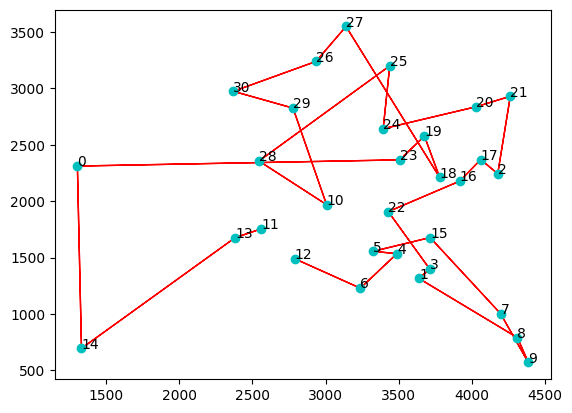

In [56]:
endPath = geneticAlgorithm(population=cityList, popSize=31, eliteSize=5, mutationRate=0, generations=100)
citiesArray = [(city.x, city.y) for city in endPath]
coordinate_to_index = {(int(val[1]), int(val[2])): int(val[0]) for val in cities}
route_indexes = [coordinate_to_index[coordinate]-1 for coordinate in citiesArray]
print(route_indexes)

plot(points, route_indexes)

Note:

The *initial population size* parameter is stored in *popSize* variable.

The *number of generations* parameter is stored in *generations* variable.

The *mutation rate* parameter is stored in *mutationRate* variable.

### Visualize the Genetic algorithm performance

In [57]:
def geneticAlgorithmPlot(population, popSize, eliteSize, mutationRate, generations):
    pop = initialPopulation(popSize, population)
    progress = []
    progress.append(1 / rankRoutes(pop)[0][1])

    for i in range(0, generations):
        pop = nextGeneration(pop, eliteSize, mutationRate)
        progress.append(1 / rankRoutes(pop)[0][1])

    plt.plot(progress)
    plt.ylabel('Distance')
    plt.xlabel('Generation')
    plt.show()

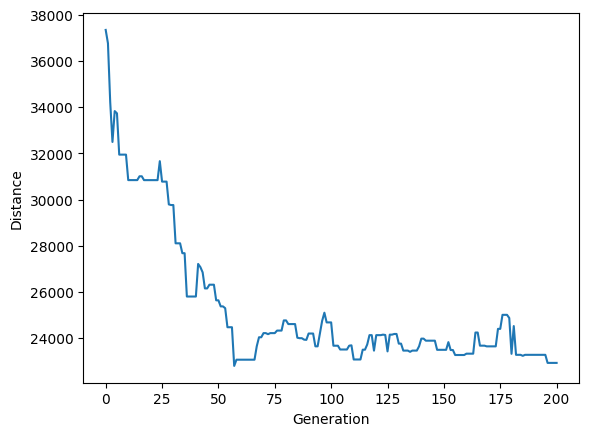

In [58]:
geneticAlgorithmPlot(population=cityList, popSize=31, eliteSize=5, mutationRate=0.01, generations=200)

Note: When changing the parameter *popSize*, remeber to change the value of *eliteSize* as well. Elite size is a subset of the population size.